In [1]:
import os
import sys

sys.path.append("/home/lsys/private_blacklight/venv/lib/python3.10/site-packages")

import json
import pandas as pd
import janitor
import numpy as np
from utilities import load_visit_data, get_registered_domain, init_mpl_fig, save_mpl_fig

bl_json_path = "../data/blacklight_json/"
ddg_entities_path = "../data/tracker-radar/entities"

import warnings

warnings.filterwarnings("ignore")

from inequality.gini import Gini

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook", font_scale=1.2, style="whitegrid", palette="dark")
# from matplotlib.ticker import FuncFormatter
# from adjustText import adjust_text

Checking that all paths exist:
{'web_mobile': True, 'web_desktop': True, 'web': True, 'yg_profile': True, 'blacklight': True, 'who': True}


In [2]:
df_visits = (
    load_visit_data()
    .reset_index(names="visitid")
    .reorder_columns(["caseid", "visitid"])
)

df_visits.head()

len(df_visits)=6,297,382


,caseid,visitid,private_domain,category,visit_time_local,visit_duration,page_views,source
0,205323077,0,google.com,Search Engines and Portals,2022-05-31 23:52:37,2,1,mobile_web
1,205323077,1,coupons.com,"Business, Shopping",2022-06-01 01:07:35,457,10,mobile_web
2,205323077,2,google.com,Business,2022-06-01 01:15:12,55,1,mobile_web
3,205323077,3,coupons.com,"Business, Shopping",2022-06-01 01:16:07,2225,4,mobile_web
4,205323077,4,google.com,Search Engines and Portals,2022-06-01 04:38:10,10,1,mobile_web


## Prep ddg

In [3]:
domain_to_org = {}

for filename in os.listdir(ddg_entities_path):
    if filename.endswith(".json"):
        with open(
            os.path.join(ddg_entities_path, filename), "r", encoding="utf-8"
        ) as f:
            data = json.load(f)
            entity_name = data.get("name")
            for domain in data.get("properties", []):
                domain_to_org[domain] = entity_name

print(len(domain_to_org))
dict(list(domain_to_org.items())[:10])

38210


{'gmu.edu': 'George Mason University',
 'dogstrust.org.uk': 'Dogs Trust Limited',
 'isn.ag': 'Snagajob, Inc.',
 'snagajob.com': 'Snagajob, Inc.',
 'omeda.com': 'Omeda Communications',
 'farmandfleet.com': 'Blain Supply, Inc.',
 'devk.de': 'DEVK Dt.Eisenb.Vers.Sach-&HUK-Vers.ver. aG Betr.Soz.einr.d.DB',
 'shadowstats.com': 'Shadow Government Statistics',
 'getsatisfaction.com': 'Get Satisfaction',
 'trivago.com': 'trivago N.V.'}

In [4]:
len(set(domain_to_org.values()))

19155

In [5]:
# get all 3p domain per private domain
records = []

for filename in os.listdir(bl_json_path):
    if filename.endswith(".json"):
        filepath = os.path.join(bl_json_path, filename)
        with open(filepath, "r", encoding="utf-8") as f:
            data = json.load(f)

            domain = data.get("host", filename.replace(".json", ""))
            third_parties = (
                data.get("hosts", {}).get("requests", {}).get("third_party", [])
            )

            for tp in third_parties:
                records.append({"private_domain": domain, "third_party_domain": tp})

df = (
    pd.DataFrame(records)
    # normalize domain to be consistent with ddg
    .assign(
        norm_third_party_domain=lambda d: d["third_party_domain"].map(
            get_registered_domain
        )
    ).assign(org=lambda df_: df_["norm_third_party_domain"].map(domain_to_org))
)
df.head()

,private_domain,third_party_domain,norm_third_party_domain,org
0,onuniverse.com,image.mux.com,mux.com,"Mux, Inc."
1,onuniverse.com,www.googletagmanager.com,googletagmanager.com,Google LLC
2,onuniverse.com,connect.facebook.net,facebook.net,"Facebook, Inc."
3,onuniverse.com,www.google-analytics.com,google-analytics.com,Google LLC
4,onuniverse.com,www.facebook.com,facebook.com,"Facebook, Inc."


In [6]:
len(df.query("org!=org"))

87553

In [7]:
df.query("org!=org")

,private_domain,third_party_domain,norm_third_party_domain,org
51,tonightshookup.com,s01.ndcdn.com,ndcdn.com,NaN
52,tonightshookup.com,s03.ndcdn.com,ndcdn.com,NaN
58,maysfuneralhome.com,api.gather.app,gather.app,NaN
74,wdyt.com.au,qnabot.com,qnabot.com,NaN
79,wdyt.com.au,js.go2sdk.com,go2sdk.com,NaN
...,...,...,...,...
848158,nudebeautyteen.com,mauc.yomeno.xyz,yomeno.xyz,NaN
848167,lexingtonsheriff.net,jelly.mdhv.io,mdhv.io,NaN
848168,lexingtonsheriff.net,jelly-v6.mdhv.io,mdhv.io,NaN
848210,oldhavanacasino.eu,fw-cdn.com,fw-cdn.com,NaN


In [8]:
len(df.query("org==org"))

760712

In [9]:
df["private_domain"].nunique()

30829

In [45]:
df["third_party_domain"].nunique()

51094

In [46]:
df.query("org==org")["third_party_domain"].nunique()

30898

In [47]:
df["org"].nunique()

2571

In [12]:
df_domain_orgs = (
    df
    .dropna(subset=["org"], ignore_index=True)
    .select_columns(["private_domain", "org"])
    # ensure org w/ multiple 3p domain only counted once
    .drop_duplicates()
)
df_domain_orgs

,private_domain,org
0,onuniverse.com,"Mux, Inc."
1,onuniverse.com,Google LLC
2,onuniverse.com,"Facebook, Inc."
8,yumacounty.net,Google LLC
14,adnimation.com,Google LLC
...,...,...
760706,hookups2day.com,Max Lynch
760707,hookups2day.com,"Cloudflare, Inc."
760708,hookups2day.com,OpenJS Foundation
760709,hookups2day.com,"Amazon Technologies, Inc."


## Merge ddg to visits

In [13]:
# collape to individual-org level
df_individual_org_histshare = (
    df_visits.merge(df_domain_orgs, on="private_domain", how="right", validate="m:m")
    # ------------------------------------------------
    # count how many visits by individual is seen by org
    .groupby(["caseid", "org"])
    .size()
    .rename("captured_visits")
    .reset_index()
    # ------------------------------------------------
    # get total visits per individual
    .merge(
        (df_visits.groupby("caseid").size().rename("total_visits")),
        how="left",
        on="caseid",
        validate="m:1",
    )
    .assign(captured_hist=lambda df_: df_["captured_visits"] / df_["total_visits"])
    # ------------------------------------------------
    .sort_values(["caseid", "captured_hist"], ascending=(True, False))
)
df_individual_org_histshare

,caseid,org,captured_visits,total_visits,captured_hist
178,47541,Google LLC,10467,17229,0.607522
245,47541,Microsoft Corporation,7700,17229,0.446921
230,47541,"Magnite, Inc.",4754,17229,0.275930
468,47541,Yahoo Inc.,4719,17229,0.273899
29,47541,"Amazon Technologies, Inc.",4703,17229,0.272970
...,...,...,...,...,...
271654,343466645,Throtle,2,1029,0.001944
271655,343466645,TransUnion LLC,2,1029,0.001944
271656,343466645,TripleLift,2,1029,0.001944
271659,343466645,Verizon,2,1029,0.001944


In [14]:
df_individual_org_histshare["caseid"].nunique()

1132

## Analyse

In [15]:
summ_table_lab = {
    "count": "n",
    "mean": "Mean",
    "std": "SD",
    "min": "Min.",
    "25%": "25p",
    "50%": "50p",
    "75%": "75p",
    "max": "Max.",
}

### How many tracking organizations are watching each user

In [16]:
df_ind_num_orgs = (
    df_individual_org_histshare.groupby("caseid")["org"]
    .nunique()
    .reset_index(name="n_orgs")
)
df_ind_num_orgs

,caseid,n_orgs
0,47541,495
1,56565,371
2,203271,151
3,216457,110
4,257495,288
...,...,...
1127,342376013,284
1128,342383477,112
1129,343144813,11
1130,343195461,102


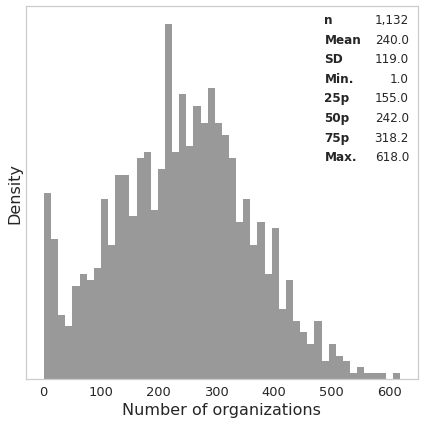

In [17]:
# plot
_, ax = init_mpl_fig((6, 6), 1)

sns.histplot(
    df_ind_num_orgs["n_orgs"],
    bins=50,
    stat="density",
    color=".5",
    alpha=0.8,
    edgecolor="None",
    linewidth=0,
    element="step",
    fill=True,
    kde=False,
    ax=ax,
)

# ============================================================================
labsize = 16
ax.set_xlabel("Number of organizations", fontsize=labsize)
ax.set_ylabel("Density", fontsize=labsize)
ax.set_yticks([])
# ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}%"))
ax.tick_params(axis="both", labelsize=13, pad=0)
ax.grid(False)
plt.tight_layout()

save_mpl_fig("../figures/dist_org_per_user")

# ============================================================================
# Compute summary table
summary_stats = (
    df_ind_num_orgs["n_orgs"]
    .describe()
    .round(1)
    .loc[summ_table_lab.keys()]
    .rename(summ_table_lab)
    .to_frame(name="Value")
    .rename_axis("Stat")
    .reset_index()
    .assign(
        Value=lambda d: d.apply(
            lambda row: f"{int(row['Value']):,}"
            if row["Stat"] == "n"
            else row["Value"],
            axis=1,
        )
    )
)

# ============================================================================
# Add summary table
table = ax.table(
    cellText=summary_stats.values,
    cellLoc="left",
    # (left, bottom, width, height) in axes coords
    bbox=[0.75, 0.57, 0.24, 0.42],
)

table.auto_set_font_size(False)
table.set_fontsize(12)

for (row, col), cell in table.get_celld().items():
    # Bold first column
    if col == 0:
        cell.set_text_props(weight="bold")
        cell.get_text().set_ha("left")
    elif col == 1:
        cell.get_text().set_ha("right")
    # remove borders
    cell.set_linewidth(0)

save_mpl_fig("../figures/dist_org_per_user_summtable")

### Distribution of Org Tracking Concentration Across Individuals

In [18]:
# compute gini
# minimum n_org required to enter compute
_threshold = 10
valid_caseid = df_ind_num_orgs.query(f"n_orgs >= {_threshold}")["caseid"]

df_gini = (
    df_individual_org_histshare.query("caseid in @valid_caseid")
    .groupby("caseid")["captured_hist"]
    .apply(lambda x: Gini(x.values).g)
    .reset_index(name="gini_exposure")
)
df_gini

,caseid,gini_exposure
0,47541,0.854956
1,56565,0.815088
2,203271,0.832871
3,216457,0.676575
4,257495,0.815267
...,...,...
1101,342376013,0.803874
1102,342383477,0.762383
1103,343144813,0.804795
1104,343195461,0.611527


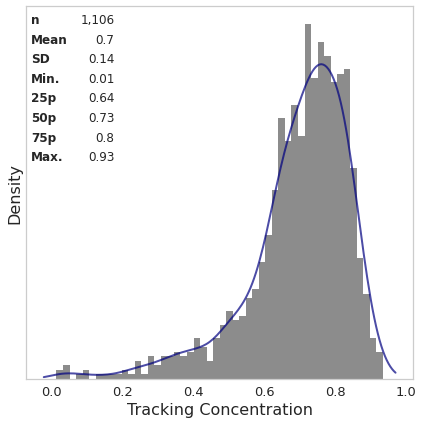

In [19]:
_, ax = init_mpl_fig((6, 6), 1)

sns.histplot(
    df_gini["gini_exposure"],
    bins=50,
    kde=False,
    color=".5",
    alpha=0.9,
    edgecolor="None",
    linewidth=0,
    element="step",
    stat="density",
    ax=ax,
)

sns.kdeplot(
    df_gini["gini_exposure"],
    bw_adjust=1,
    cut=1,
    color="navy",
    alpha=0.7,
    lw=2,
    ax=ax,
)

# ============================================================================
labsize = 16
plt.xlabel("Tracking Concentration", fontsize=labsize)
ax.set_ylabel("Density", fontsize=labsize)
ax.set_yticks([])
# ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}%"))
ax.tick_params(axis="both", labelsize=13, pad=0)
ax.grid(False)
plt.tight_layout()

save_mpl_fig("../figures/dist_tracking_concentration_per_user")

# ============================================================================
summary_stats = (
    df_gini["gini_exposure"]
    .describe()
    .round(2)
    .loc[summ_table_lab.keys()]
    .rename(summ_table_lab)
    .to_frame(name="Value")
    .rename_axis("Stat")
    .reset_index()
    .assign(
        Value=lambda d: d.apply(
            lambda row: f"{int(row['Value']):,}"
            if row["Stat"] == "n"
            else row["Value"],
            axis=1,
        )
    )
)

# ============================================================================
# Add summary table
table = ax.table(
    cellText=summary_stats.values,
    cellLoc="left",
    # (left, bottom, width, height) in axes coords
    bbox=[0.0, 0.57, 0.24, 0.42],
)

table.auto_set_font_size(False)
table.set_fontsize(12)

for (row, col), cell in table.get_celld().items():
    # Bold first column
    if col == 0:
        cell.set_text_props(weight="bold")
        cell.get_text().set_ha("left")
    elif col == 1:
        cell.get_text().set_ha("right")
    # remove borders
    cell.set_linewidth(0)

save_mpl_fig("../figures/dist_tracking_concentration_per_user_summtable")

### Tracking Breadth vs. Concentration

In [20]:
df_n_owners = (
    df_individual_org_histshare.groupby("caseid")["org"]
    .nunique()
    .reset_index(name="n_orgs")
)
df_n_owners

,caseid,n_orgs
0,47541,495
1,56565,371
2,203271,151
3,216457,110
4,257495,288
...,...,...
1127,342376013,284
1128,342383477,112
1129,343144813,11
1130,343195461,102


In [21]:
df_gini = df_gini.merge(df_n_owners, on="caseid")
df_gini.head(3)

,caseid,gini_exposure,n_orgs
0,47541,0.854956,495
1,56565,0.815088,371
2,203271,0.832871,151


$$
\text{Gini}_{\text{max}} = \frac{n - 1}{n}
$$


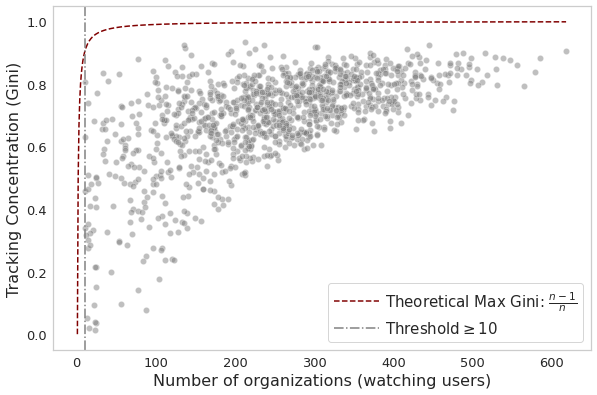

In [22]:
_, ax = init_mpl_fig((12, 8), 0.7)

sns.scatterplot(
    data=df_gini, x="n_orgs", y="gini_exposure", color=".5", alpha=0.5, s=39
)

# ============================================================================
labsize = 16
plt.xlabel("Number of organizations (watching users)", fontsize=labsize)
ax.set_ylabel("Tracking Concentration (Gini)", fontsize=labsize)
ax.tick_params(axis="both", labelsize=13, pad=0)
ax.grid(False)
plt.tight_layout()

# ============================================================================
# envelop of theoretical max Gini
x = np.arange(1, df_gini["n_orgs"].max() + 1)
gini_max = (x - 1) / x

plt.plot(
    x,
    gini_max,
    color="maroon",
    linestyle="--",
    label=r"Theoretical Max Gini: $\frac{n - 1}{n}$",
)

ax.axvline(
    10,
    color=".5",
    linestyle="dashdot",
    linewidth=1.5,
    label=r"Threshold$\geq$" f"{_threshold}",
)

plt.legend(
    fontsize=15,
    handlelength=3,
    handletextpad=0.4,
)
save_mpl_fig("../figures/org_concentration_reach_by_user")

### Max browsing history per user

In [23]:
df_user_top_org_share = (
    df_individual_org_histshare.sort_values("captured_hist", ascending=False)
    .groupby("caseid", as_index=False)
    .first()
    .rename_column("captured_hist", "top_org_share")
    .select_columns(["caseid", "org", "top_org_share"])
)
df_user_top_org_share

,caseid,org,top_org_share
0,47541,Google LLC,0.607522
1,56565,Google LLC,0.595406
2,203271,Microsoft Corporation,0.362319
3,216457,Google LLC,0.765669
4,257495,Google LLC,0.597698
...,...,...,...
1127,342376013,Google LLC,0.799393
1128,342383477,Google LLC,0.690639
1129,343144813,58.com Inc.,0.502980
1130,343195461,Google LLC,0.835539


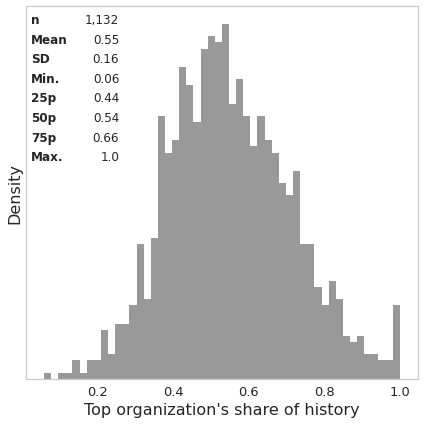

In [43]:
# plot
_, ax = init_mpl_fig((6, 6), 1)

sns.histplot(
    df_user_top_org_share["top_org_share"],
    bins=50,
    stat="percent",
    color=".5",
    alpha=0.8,
    edgecolor="none",
    linewidth=0,
    element="step",
    fill=True,
    kde=False,
    ax=ax,
)

# ============================================================================
labsize = 16
ax.set_xlabel(
    "Top organization's share of history", fontsize=labsize
)
ax.set_ylabel("Density", fontsize=labsize)
ax.set_yticks([])
# ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}%"))
ax.tick_params(axis="both", labelsize=13, pad=0)
ax.grid(False)
plt.tight_layout()

save_mpl_fig("../figures/dist_maxshare_hist")

# ============================================================================
# Compute summary table
summary_stats = (
    df_user_top_org_share["top_org_share"]
    .describe()
    .round(2)
    .loc[summ_table_lab.keys()]
    .rename(summ_table_lab)
    .to_frame(name="Value")
    .rename_axis("Stat")
    .reset_index()
    .assign(
        Value=lambda d: d.apply(
            lambda row: f"{int(row['Value']):,}"
            if row["Stat"] == "n"
            else row["Value"],
            axis=1,
        )
    )
)

# ============================================================================
# Add summary table
table = ax.table(
    cellText=summary_stats.values,
    cellLoc="left",
    # (left, bottom, width, height) in axes coords
    bbox=[0.0, 0.57, 0.25, 0.42],
)

table.auto_set_font_size(False)
table.set_fontsize(12)

for (row, col), cell in table.get_celld().items():
    # Bold first column
    if col == 0:
        cell.set_text_props(weight="bold")
        cell.get_text().set_ha("left")
    elif col == 1:
        cell.get_text().set_ha("right")
    # remove borders
    cell.set_linewidth(0)

save_mpl_fig("../figures/dist_maxshare_hist_summtable")

### Max browsing history (dwelling time)

In [25]:
# collape to individual-org level
df_individual_org_histshare_duration = (
    df_visits.merge(df_domain_orgs, on="private_domain", how="right", validate="m:m")
    .sort_values(["caseid", "visitid"], ignore_index=True)
    # ensure org w/ multiple 3p domain only counted once
    .drop_duplicates(["caseid", "visitid", "org"])
    # ------------------------------------------------
    # count duration of visits seen by org
    .groupby(["caseid", "org"])["visit_duration"]
    .sum()
    .rename("captured_duration")
    .reset_index()
    # ------------------------------------------------
    # get total duration per individual
    .merge(
        (df_visits.groupby("caseid")["visit_duration"].sum().rename("total_duration")),
        how="left",
        on="caseid",
        validate="m:1",
    )
    .assign(
        captured_hist_duration=lambda df_: df_["captured_duration"]
        / df_["total_duration"]
    )
    # ------------------------------------------------
    .sort_values(
        ["caseid", "captured_hist_duration"], ascending=(True, False), ignore_index=True
    )
)
df_individual_org_histshare_duration

,caseid,org,captured_duration,total_duration,captured_hist_duration
0,47541,Google LLC,188131,263288,0.714545
1,47541,Microsoft Corporation,148815,263288,0.565218
2,47541,Yahoo Inc.,105020,263288,0.398879
3,47541,"Amazon Technologies, Inc.",104929,263288,0.398533
4,47541,Adobe Inc.,104101,263288,0.395388
...,...,...,...,...,...
271663,343466645,"AdRoll, Inc.",16,31204,0.000513
271664,343466645,Almondnet Group,16,31204,0.000513
271665,343466645,Highsoft AS,16,31204,0.000513
271666,343466645,GoDaddy Inc.,12,31204,0.000385


In [26]:
df_user_top_org_share_duration = (
    df_individual_org_histshare_duration.sort_values(
        "captured_hist_duration", ascending=False
    )
    .groupby("caseid", as_index=False)
    .first()
    .rename_column("captured_hist_duration", "top_org_share_duration")
    .select_columns(["caseid", "org", "top_org_share_duration"])
)
df_user_top_org_share_duration

,caseid,org,top_org_share_duration
0,47541,Google LLC,0.714545
1,56565,Google LLC,0.671141
2,203271,Microsoft Corporation,0.338349
3,216457,Google LLC,0.874906
4,257495,Google LLC,0.659628
...,...,...,...
1127,342376013,Google LLC,0.811752
1128,342383477,Google LLC,0.676702
1129,343144813,58.com Inc.,0.712407
1130,343195461,Google LLC,0.934204


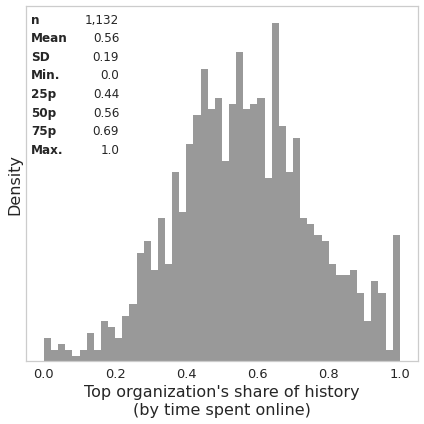

In [40]:
# plot
_, ax = init_mpl_fig((6, 6), 1)

sns.histplot(
    df_user_top_org_share_duration["top_org_share_duration"],
    bins=50,
    stat="percent",
    color=".5",
    alpha=0.8,
    edgecolor="none",
    linewidth=0,
    element="step",
    fill=True,
    kde=False,
    ax=ax,
)

# ============================================================================
labsize = 16
ax.set_xlabel(
    "Top organization's share of history\n(by time spent online)", fontsize=labsize
)
ax.set_ylabel("Density", fontsize=labsize)
ax.set_yticks([])
# ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}%"))
ax.tick_params(axis="both", labelsize=13, pad=0)
ax.grid(False)
plt.tight_layout()

save_mpl_fig("../figures/dist_maxshare_hist_duration")

# ============================================================================
# Compute summary table
summary_stats = (
    df_user_top_org_share_duration["top_org_share_duration"]
    .describe()
    .round(2)
    .loc[summ_table_lab.keys()]
    .rename(summ_table_lab)
    .to_frame(name="Value")
    .rename_axis("Stat")
    .reset_index()
    .assign(
        Value=lambda d: d.apply(
            lambda row: f"{int(row['Value']):,}"
            if row["Stat"] == "n"
            else row["Value"],
            axis=1,
        )
    )
)

# ============================================================================
# Add summary table
table = ax.table(
    cellText=summary_stats.values,
    cellLoc="left",
    # (left, bottom, width, height) in axes coords
    bbox=[0., 0.57, 0.25, 0.42],
)

table.auto_set_font_size(False)
table.set_fontsize(12)

for (row, col), cell in table.get_celld().items():
    # Bold first column
    if col == 0:
        cell.set_text_props(weight="bold")
        cell.get_text().set_ha("left")
    elif col == 1:
        cell.get_text().set_ha("right")
    # remove borders
    cell.set_linewidth(0)

save_mpl_fig("../figures/dist_maxshare_hist_duration_summtable")

### Top trackers: reach v dominance

In [28]:
df_org_reach = (
    df_individual_org_histshare.groupby("org")["caseid"]
    .nunique()
    .sort_values(ascending=False)
    .reset_index(name="n_users_seen")
)
df_org_reach

,org,n_users_seen
0,Google LLC,1129
1,Microsoft Corporation,1113
2,"Facebook, Inc.",1100
3,Adobe Inc.,1093
4,"Amazon Technologies, Inc.",1091
...,...,...
2566,Skillbrains,1
2567,Slavov Dimitar,1
2568,SlimCut Media SAS,1
2569,Cyan Blue Odds Limited,1


In [29]:
df_top_org = (
    df_individual_org_histshare.sort_values(
        ["caseid", "captured_hist"], ascending=[True, False]
    )
    .drop_duplicates("caseid")
    .groupby("org")
    .size()
    .sort_values(ascending=False)
    .reset_index(name="n_users_where_top")
)
df_top_org

,org,n_users_where_top
0,Google LLC,1007
1,"Facebook, Inc.",46
2,Microsoft Corporation,45
3,"Amazon Technologies, Inc.",12
4,"Cloudflare, Inc.",7
5,"ExoClick, S.L.",5
6,Roblox Corporation,2
7,Quora,2
8,58.com Inc.,1
9,Monotype Imaging Inc.,1


In [30]:
df_org_summary = (
    df_org_reach.merge(df_top_org, on="org", how="outer")
    .fillna(0)
    .astype({"n_users_seen": int, "n_users_where_top": int})
    .sort_values(
        ["n_users_where_top", "n_users_seen"],
        ascending=(False, False),
        ignore_index=True,
    )
)
df_org_summary

,org,n_users_seen,n_users_where_top
0,Google LLC,1129,1007
1,"Facebook, Inc.",1100,46
2,Microsoft Corporation,1113,45
3,"Amazon Technologies, Inc.",1091,12
4,"Cloudflare, Inc.",1080,7
...,...,...,...
2566,trivago N.V.,1,0
2567,webgarden s.r.o.,1,0
2568,上海聚效广告有限公司,1,0
2569,中華電信股份有限公司,1,0


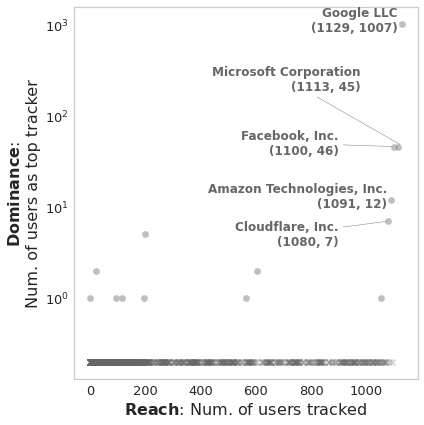

In [31]:
_, ax = init_mpl_fig((6, 6), 1)

sns.scatterplot(
    data=df_org_summary,
    x="n_users_seen",
    y="n_users_where_top",
    color=".5",
    alpha=0.5,
    s=50,
    ax=ax,
)

if True:  # plot zeroes
    df_zeros = df_org_summary.query("n_users_where_top == 0")
    ax.scatter(
        df_zeros["n_users_seen"],
        [0.2] * len(df_zeros),  # Just above log floor
        marker="x",
        color=".4",
        alpha=0.3,
    )

# ============================================================================
labsize = 16
plt.xlabel(r"$\bf{Reach}$:" " Num. of users tracked", fontsize=labsize)
ax.set_ylabel(r"$\bf{Dominance}$:" "\nNum. of users as top tracker", fontsize=labsize)
ax.tick_params(axis="both", labelsize=13, pad=0)
ax.set_yscale("log")
ax.grid(False)
plt.tight_layout()

# ============================================================================
# Manual + auto labeling
offset_x = -15  # horizontal shift
offset_multiplier = 1.1  # vertical scaling for log space

_top_threshold = 7
top_labels = df_org_summary.query(f"n_users_where_top >= {_top_threshold}").copy()

for _, row in top_labels.iterrows():
    label_str = (
        f'{row["org"]}\n({int(row["n_users_seen"])}, {int(row["n_users_where_top"])})'
    )

    if row["org"] == "Microsoft Corporation":
        ax.annotate(
            label_str,
            xy=((row["n_users_seen"] - offset_x), (row["n_users_where_top"] * 1.05)),
            xycoords="data",
            xytext=(980, 250),  # manually adjusted
            textcoords="data",
            fontsize=12,
            fontweight="bold",
            color="0.4",
            ha="right",
            va="center",
            arrowprops=dict(arrowstyle="-", color="gray", lw=0.5),
        )
    elif row["org"] == "Facebook, Inc.":
        ax.annotate(
            label_str,
            xy=(row["n_users_seen"], row["n_users_where_top"]),
            xycoords="data",
            xytext=(900, 50),  # manually adjusted
            textcoords="data",
            fontsize=12,
            fontweight="bold",
            color="0.4",
            ha="right",
            va="center",
            arrowprops=dict(arrowstyle="-", color="gray", lw=0.5),
        )
    elif row["org"] == "Cloudflare, Inc.":
        ax.annotate(
            f'{row["org"]}\n({int(row["n_users_seen"])}, {int(row["n_users_where_top"])})',
            xy=(row["n_users_seen"], row["n_users_where_top"]),
            xycoords="data",
            xytext=(900, 5),
            textcoords="data",
            fontsize=12,
            fontweight="bold",
            color="0.4",
            ha="right",
            va="center",
            arrowprops=dict(arrowstyle="-", color="gray", lw=0.5),
        )
    else:
        ax.text(
            row["n_users_seen"] + offset_x,
            row["n_users_where_top"] * offset_multiplier,
            label_str,
            fontsize=12,
            fontweight="bold",
            color="0.4",
            ha="right",
            va="center",
            rotation=0,
        )

save_mpl_fig("../figures/top_trackers_reach_dominance_annotated_top_orgs")

### Organization market share

In [32]:
df_org_power = (
    df_individual_org_histshare.groupby("org")["captured_visits"]
    .sum()
    # highest below
    .sort_values(ascending=True)
    .reset_index(name="tt_captured_visits")
    .assign(
        cum_share=lambda df_: df_["tt_captured_visits"].cumsum()
        / df_["tt_captured_visits"].sum(),
        prop_orgs=lambda df_: np.linspace(0, 1, len(df_)),
    )
)
df_org_power

,org,tt_captured_visits,cum_share,prop_orgs
0,Market Data Limited,1,2.718687e-08,0.000000
1,"Charity Navigator, Inc.",1,5.437374e-08,0.000389
2,Johns Hopkins University,1,8.156061e-08,0.000778
3,Paylocity Corporation,1,1.087475e-07,0.001167
4,Bobit Business Media,1,1.359343e-07,0.001556
...,...,...,...,...
2566,Adobe Inc.,841010,8.182346e-01,0.998444
2567,"Amazon Technologies, Inc.",890323,8.424397e-01,0.998833
2568,"Facebook, Inc.",1067213,8.714539e-01,0.999222
2569,Microsoft Corporation,1396043,9.094079e-01,0.999611


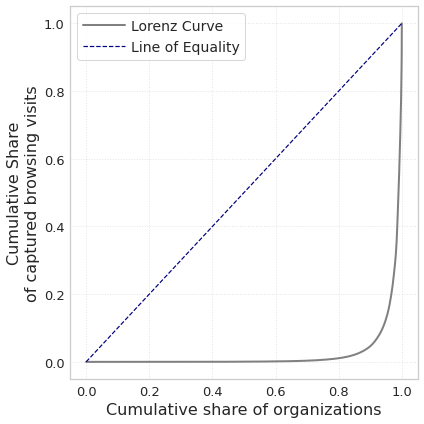

In [33]:
_, ax = init_mpl_fig((6, 6), 1)

plt.plot(
    df_org_power["prop_orgs"],
    df_org_power["cum_share"],
    color=".5",
    linewidth=2,
    label="Lorenz Curve",
)

plt.plot(
    [0, 1],
    [0, 1],
    linestyle="--",
    color="navy",
    linewidth=1.2,
    label="Line of Equality",
)

labsize = 16
plt.xlabel("Cumulative share of organizations", fontsize=labsize)
plt.ylabel("Cumulative Share\nof captured browsing visits", fontsize=labsize)
ax.tick_params(axis="both", labelsize=13, pad=0)
plt.grid(axis="both", linestyle=":", alpha=0.5)

plt.legend(
    fontsize=14,
    handlelength=3,
    handletextpad=0.4,
)
plt.tight_layout()
save_mpl_fig("../figures/lorenz_org_share_browsinghist")

### Num visits w/ trackers

In [34]:
# collape to individual-org level
df_individual_visit_w_tracker = (
    df_visits.merge(df_domain_orgs, on="private_domain", how="right", validate="m:m")
    # ------------------------------------------------
    # count how many visits by individual is seen by org
    .drop_duplicates(["caseid", "visitid"])
    .groupby("caseid")
    .size()
    .rename("captured_visits")
    .reset_index()
    # ------------------------------------------------
    # get total visits per individual
    .merge(
        (df_visits.groupby("caseid").size().rename("total_visits")),
        how="left",
        on="caseid",
        validate="m:1",
    )
    .assign(captured_visits=lambda df_: df_["captured_visits"] / df_["total_visits"])
    #     # ------------------------------------------------
    #     .sort_values(["caseid", "captured_hist"], ascending=(True, False))
)
df_individual_visit_w_tracker

,caseid,captured_visits,total_visits
0,47541,0.794358,17229
1,56565,0.765161,11493
2,203271,0.729825,6555
3,216457,0.808583,1771
4,257495,0.707453,10077
...,...,...,...
1127,342376013,0.863523,5598
1128,342383477,0.802511,876
1129,343144813,0.679380,839
1130,343195461,0.835539,529


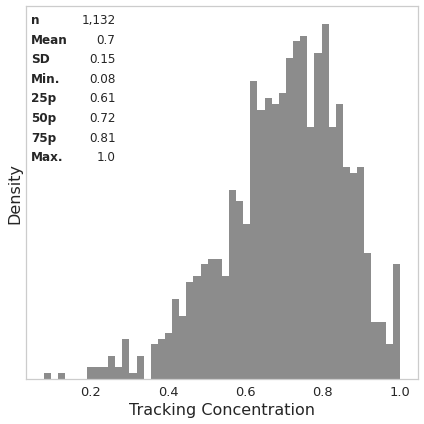

In [35]:
_, ax = init_mpl_fig((6, 6), 1)

sns.histplot(
    df_individual_visit_w_tracker["captured_visits"],
    bins=50,
    kde=False,
    color=".5",
    alpha=0.9,
    edgecolor="None",
    linewidth=0,
    element="step",
    stat="density",
    ax=ax,
)

# ============================================================================
labsize = 16
plt.xlabel("Tracking Concentration", fontsize=labsize)
ax.set_ylabel("Density", fontsize=labsize)
ax.set_yticks([])
# ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.1f}%"))
ax.tick_params(axis="both", labelsize=13, pad=0)
ax.grid(False)
plt.tight_layout()

save_mpl_fig("../figures/dist_tracked_visits")

# ============================================================================
summary_stats = (
    df_individual_visit_w_tracker["captured_visits"]
    .describe()
    .round(2)
    .loc[summ_table_lab.keys()]
    .rename(summ_table_lab)
    .to_frame(name="Value")
    .rename_axis("Stat")
    .reset_index()
    .assign(
        Value=lambda d: d.apply(
            lambda row: f"{int(row['Value']):,}"
            if row["Stat"] == "n"
            else row["Value"],
            axis=1,
        )
    )
)

# ============================================================================
# Add summary table
table = ax.table(
    cellText=summary_stats.values,
    cellLoc="left",
    # (left, bottom, width, height) in axes coords
    bbox=[0.0, 0.57, 0.24, 0.42],
)

table.auto_set_font_size(False)
table.set_fontsize(12)

for (row, col), cell in table.get_celld().items():
    # Bold first column
    if col == 0:
        cell.set_text_props(weight="bold")
        cell.get_text().set_ha("left")
    elif col == 1:
        cell.get_text().set_ha("right")
    # remove borders
    cell.set_linewidth(0)

save_mpl_fig("../figures/dist_tracked_visits_summtable")

## Individual-level derived tracking measures

* concentration in exposure to orgs (`df_gini`)
* number of orgs (`df_ind_num_orgs`)
* max hist --- *visits* ---leaked to any org (`df_user_top_org_share`)
* max hist --- *duration* --- leaked to any org (`df_user_top_org_share_duration`)
* number of visits w/ trackers (`df_individual_visit_w_tracker`)

In [36]:
_merge_opts = dict(on="caseid", how="left", validate="1:1")

df_ind = (
    pd.read_csv("../data/combined_yg_bl_who.csv")
    # -------------------------------------------------------------
    # number of orgs tracking
    .merge(df_ind_num_orgs, **_merge_opts)
    .assign(n_orgs=lambda df_: df_["n_orgs"].fillna(0).apply(int))
    # -------------------------------------------------------------
    # Max hist leaked to org
    .merge(df_user_top_org_share.remove_columns("org"), **_merge_opts)
    .assign(top_org_share=lambda df_: df_["top_org_share"].fillna(0))
    # -------------------------------------------------------------
    # Max hist leaked to org --- by duration
    .merge(df_user_top_org_share_duration.remove_columns("org"), **_merge_opts)
    .assign(top_org_share_duration=lambda df_: df_["top_org_share_duration"].fillna(0))
    # -------------------------------------------------------------
    # concentration
    .merge(df_gini.remove_columns("n_orgs"), **_merge_opts)
    # -------------------------------------------------------------
    .merge(
        df_individual_visit_w_tracker.select_columns(["caseid", "captured_visits"]),
        **_merge_opts,
    )
    .assign(captured_visits=lambda df_: df_["captured_visits"].fillna(0))
)
df_ind.to_csv("../data/combined_yg_bl_who_derived_hist_tracking.csv")
df_ind

,caseid,tt_visits,tt_domains,bl_ddg_join_ads,bl_third_party_cookies,bl_canvas_fingerprinting,bl_session_recording,bl_key_logging,bl_fb_pixel,bl_google_analytics,...,who_adult_advertising_rate,who_adult_advertising_al1,who_adult_advertising_al3,who_adult_advertising_al5,who_adult_advertising_al10,n_orgs,top_org_share,top_org_share_duration,gini_exposure,captured_visits
0,47541,17194,553,3107.0,4238.0,44.0,51.0,23.0,90.0,9.0,...,0.000000,False,False,False,False,495,0.607522,0.714545,0.854956,0.794358
1,56565,11479,334,1606.0,2193.0,18.0,16.0,11.0,44.0,5.0,...,0.000000,False,False,False,False,371,0.595406,0.671141,0.815088,0.765161
2,203271,6540,152,308.0,514.0,6.0,10.0,1.0,7.0,1.0,...,0.000000,False,False,False,False,151,0.362319,0.338349,0.832871,0.729825
3,216457,1770,49,146.0,234.0,7.0,4.0,1.0,4.0,1.0,...,0.000000,False,False,False,False,110,0.765669,0.874906,0.676575,0.808583
4,257495,10012,284,874.0,1149.0,21.0,15.0,10.0,29.0,5.0,...,0.000000,False,False,False,False,288,0.597698,0.659628,0.815267,0.707453
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,342376013,5573,108,916.0,1205.0,11.0,4.0,1.0,12.0,2.0,...,0.000000,False,False,False,False,284,0.799393,0.811752,0.803874,0.863523
1130,342383477,869,39,147.0,58.0,3.0,3.0,1.0,6.0,0.0,...,0.000000,False,False,False,False,112,0.690639,0.676702,0.762383,0.802511
1131,343144813,839,25,5.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,False,False,False,False,11,0.502980,0.712407,0.804795,0.679380
1132,343195461,529,34,172.0,133.0,2.0,2.0,0.0,4.0,0.0,...,0.567108,True,True,False,False,102,0.835539,0.934204,0.611527,0.835539
